# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import datetime

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Читаем данные

In [23]:
df = pd.read_csv('spx.csv') # Стоимость индекса акций S&P 500
df = df.iloc[:, :2]
df.index = df.Date
df.drop(['Date'],axis = 1,inplace = True)
df.index = pd.to_datetime(df.index)
df.head()

,Close/Last
Date,
2022-10-28,3901.06
2022-10-27,3807.30
2022-10-26,3830.60
2022-10-25,3859.11
2022-10-24,3797.34


Сортируем по дате

In [24]:
df.sort_index(ascending=True, inplace=True)
df.head()

,Close/Last
Date,
2012-10-29,1411.94
2012-10-30,1411.94
2012-10-31,1412.16
2012-11-01,1427.59
2012-11-02,1414.20


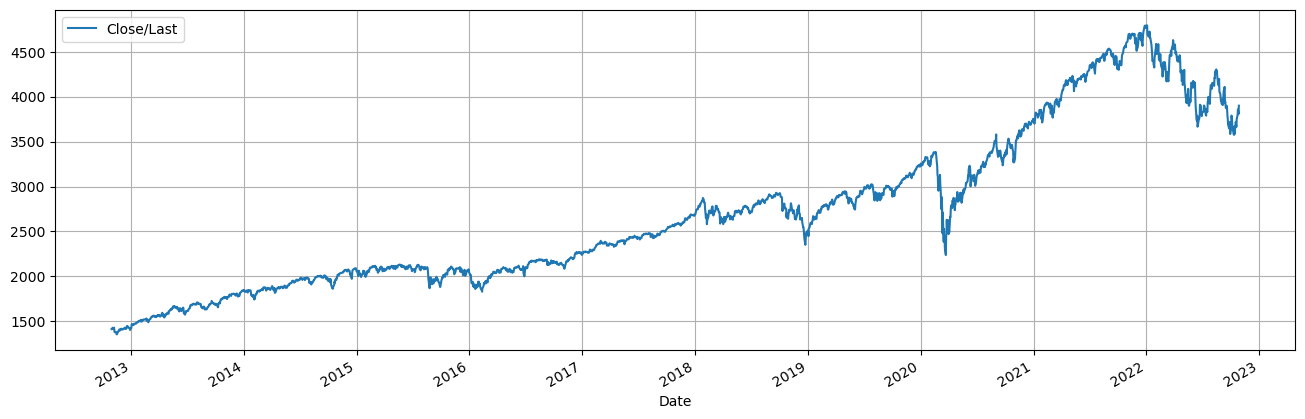

In [25]:
df.plot(figsize = (16,5))

plt.grid('On')
plt.show()

In [26]:
scaler=MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Close/Last']])
data_scaled.shape

(2548, 1)

In [27]:
train_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - train_size
X_train, X_test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print(X_train.shape, X_test.shape)

(1707, 1) (841, 1)


In [28]:
def make_train_test(X_train, X_test, look_back):
    x=[]
    for i in range(X_train.shape[0]-look_back):
        row = X_train[i:i+look_back+1]
        x.append(row)

    x=np.array(x)
    X_train = x[:,:-1] 
    Y_train = x[:,-1,0]

    print(X_train.shape ,Y_train.shape)

    x=[]
    for i in range(X_test.shape[0]-look_back):
        row = X_test[i:i+look_back+1]
        x.append(row)

    x=np.array(x)
    X_test = x[:,:-1] 
    Y_test = x[:,-1,0]
    
    X_train = X_train.reshape(-1,1,look_back)
    X_test = X_test.reshape(-1,1,look_back)

    return X_train, Y_train, X_test, Y_test

In [37]:
def check_model(model, X_test, Y_test):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    Y_test = Y_test.reshape(-1,1)
    Y_test = scaler.inverse_transform(Y_test)

    plt.plot(Y_test, label='Actual Close Price', color='green')
    plt.plot(predictions, label='Predicted Close Price', color='red')
    plt.legend(loc='best')
    plt.xlabel('Day')
    plt.ylabel('Close Price')
    plt.show()
    
    r2 = r2_score(Y_test, predictions)
    mse = mean_squared_error(Y_test, predictions)
    print(f'r2_score={r2}, mse={mse}')

In [30]:
look_back = 10 # Делем батчи по look_back шт.
X_train, Y_train, X_test, Y_test = make_train_test(X_train, X_test, look_back)
print(X_test.shape ,Y_test.shape)

(1697, 10, 1) (1697,)
(831, 1, 10) (831,)


### Модели LSTM

In [57]:
batch_size=32
epochs=20

### Простая модель с разным числом ядер


Число нейронов - 4

26/26 [==============================] - 1s 3ms/step


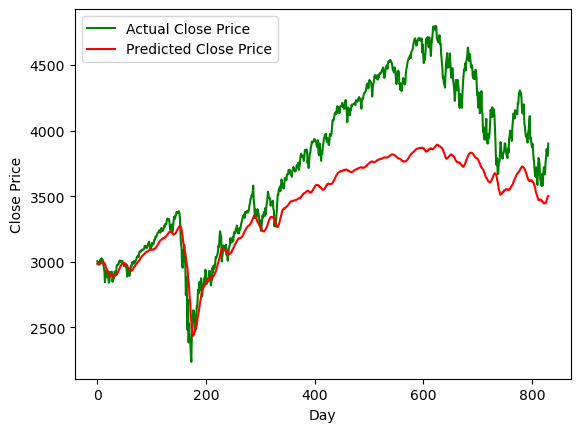

r2_score=0.5216395074334197, mse=173191.7035862387

Число нейронов - 30

26/26 [==============================] - 1s 3ms/step


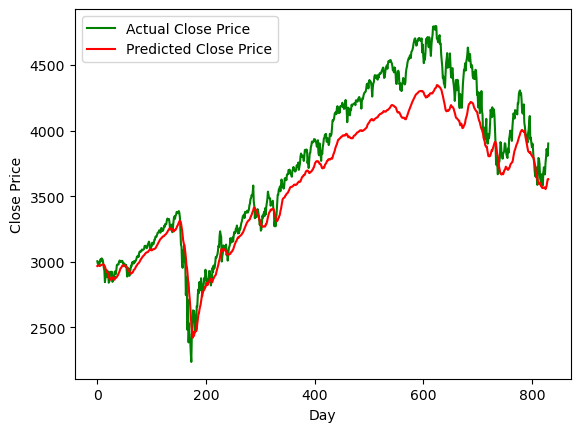

r2_score=0.8821246829677812, mse=42677.07573015449

Число нейронов - 50

26/26 [==============================] - 1s 3ms/step


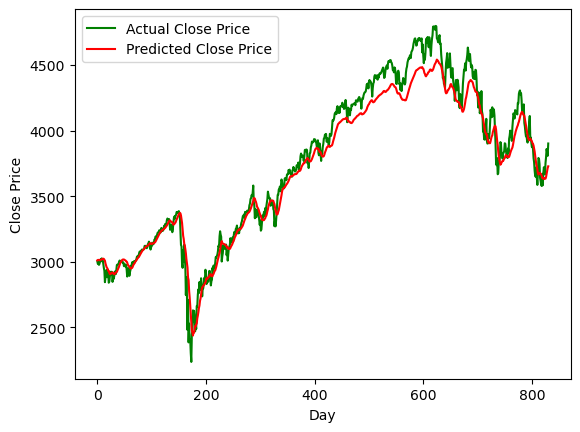

r2_score=0.9596621276702938, mse=14604.43522487101

Число нейронов - 100

26/26 [==============================] - 1s 3ms/step


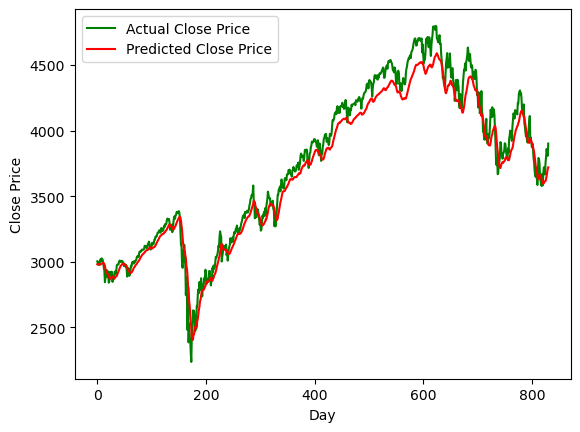

r2_score=0.964657505020963, mse=12795.84541266343

Число нейронов - 200

26/26 [==============================] - 1s 2ms/step


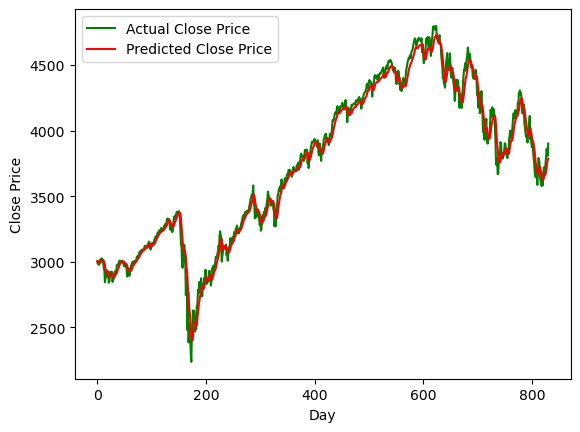

r2_score=0.9864879251979203, mse=4892.083042646271


In [60]:
neurons = [4, 30, 50, 100, 200]
for neuron in neurons:
    model=Sequential()
    model.add(LSTM(neuron, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(LSTM(neuron, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    print(f'\nЧисло нейронов - {neuron}\n')
    check_model(model, X_test, Y_test)

Наблюдение: чем больше нейронов - тем точнее прогноз

### Разное число слоев


Общее число слоев LSTM - 2 х 50 нейронов

26/26 [==============================] - 1s 3ms/step


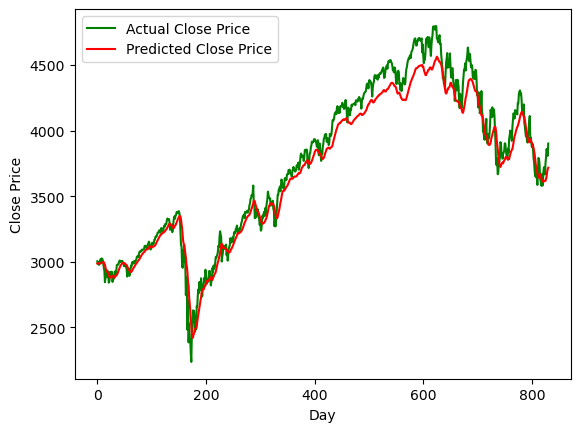

r2_score=0.9609116892491698, mse=14152.02809270943

Общее число слоев LSTM - 2 х 50 нейронов

26/26 [==============================] - 1s 5ms/step


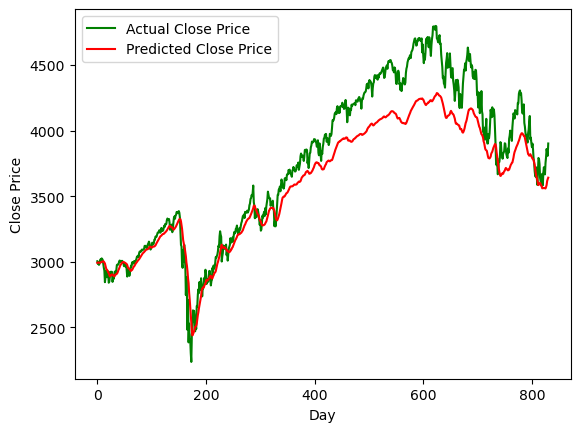

r2_score=0.8584479962137269, mse=51249.2838826529

Общее число слоев LSTM - 3 х 50 нейронов

26/26 [==============================] - 1s 5ms/step


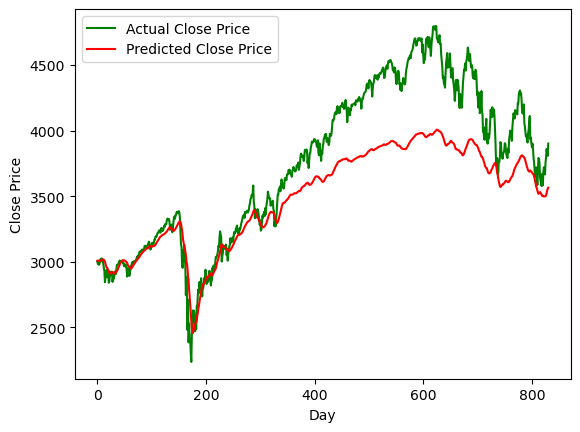

r2_score=0.6579127854196634, mse=123853.5965843657

Общее число слоев LSTM - 4 х 50 нейронов

26/26 [==============================] - 1s 5ms/step


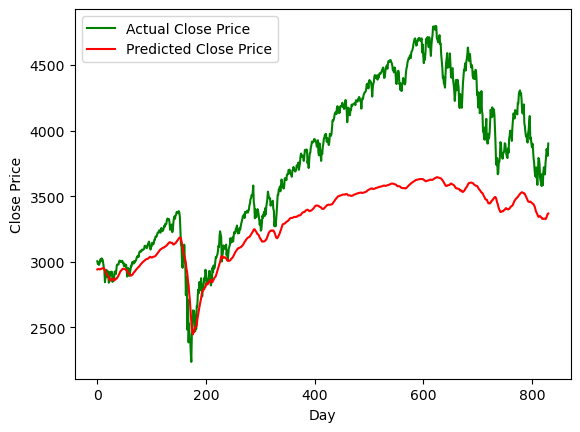

r2_score=0.13508568039214497, mse=313144.55687029316

Общее число слоев LSTM - 5 х 50 нейронов

26/26 [==============================] - 1s 6ms/step


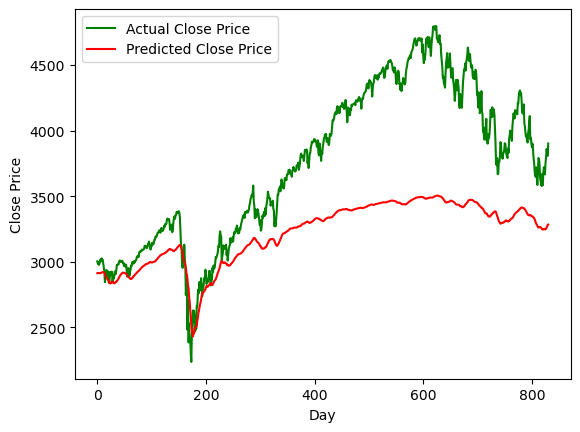

r2_score=-0.15618277572326855, mse=418599.08520080923


In [76]:
extra_layers = [0, 1, 2, 3, 4]
for layer in extra_layers:
    model=Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    for layer in range(layer):
        model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    print(f'\nОбщее число слоев LSTM - {layer+2} х 50 нейронов\n')
    check_model(model, X_test, Y_test)

Наблюдение: увеличение числа слоев ухудшает точность

### Поэкспериментируем с исходными данными

(1706, 1, 1) (1706,)
look_back = 1

27/27 [==============================] - 1s 3ms/step


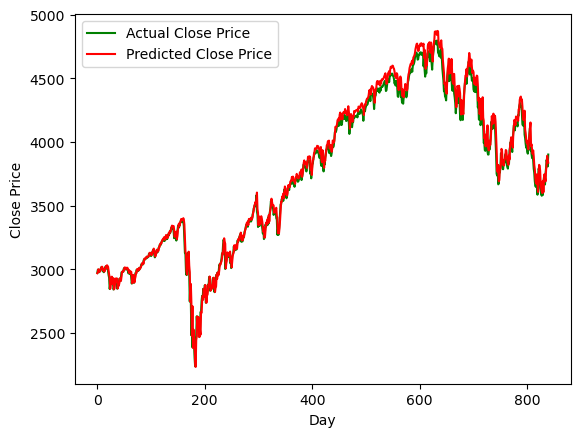

r2_score=0.989027359127227, mse=3995.0964975280554
(1702, 5, 1) (1702,)
look_back = 5

27/27 [==============================] - 1s 2ms/step


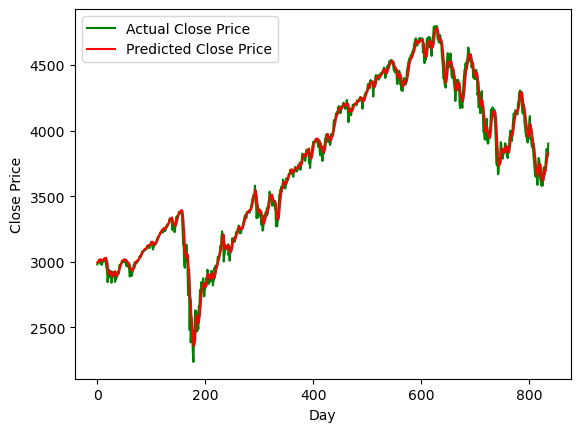

r2_score=0.988762242700145, mse=4080.9331677237215
(1697, 10, 1) (1697,)
look_back = 10

26/26 [==============================] - 1s 2ms/step


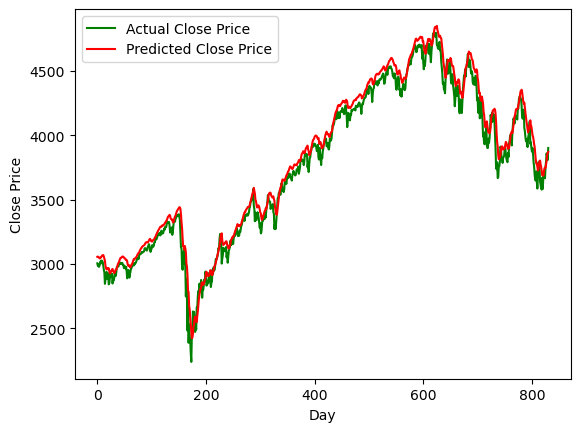

r2_score=0.9769748508208259, mse=8336.317220246654
(1687, 20, 1) (1687,)
look_back = 20

26/26 [==============================] - 1s 2ms/step


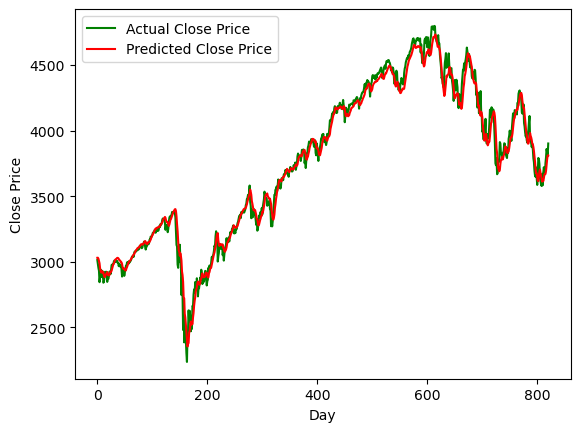

r2_score=0.9865214838405363, mse=4848.784290206342
(1677, 30, 1) (1677,)
look_back = 30

26/26 [==============================] - 1s 2ms/step


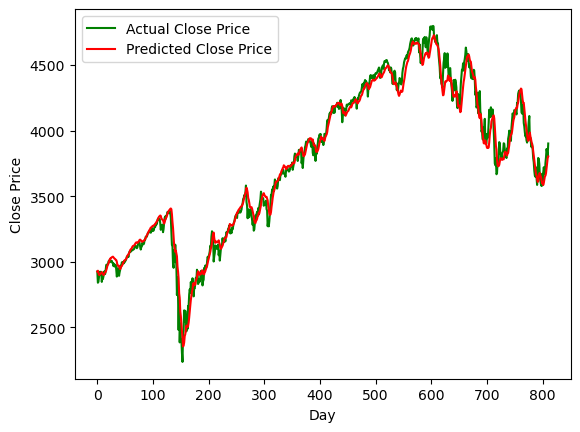

r2_score=0.9837003489608024, mse=5796.578933579739
(1657, 50, 1) (1657,)
look_back = 50

25/25 [==============================] - 1s 2ms/step


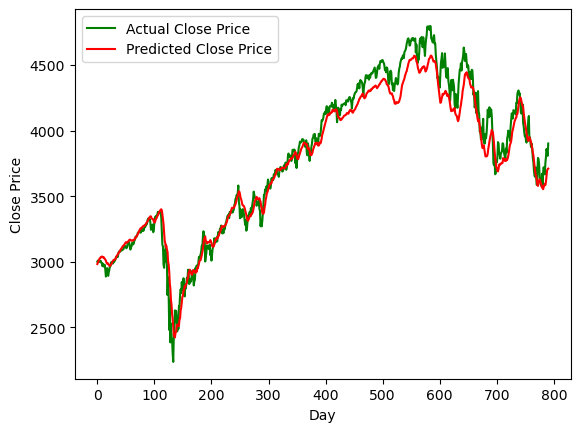

r2_score=0.9626276285155794, mse=12931.194517359307
(1607, 100, 1) (1607,)
look_back = 100

24/24 [==============================] - 0s 2ms/step


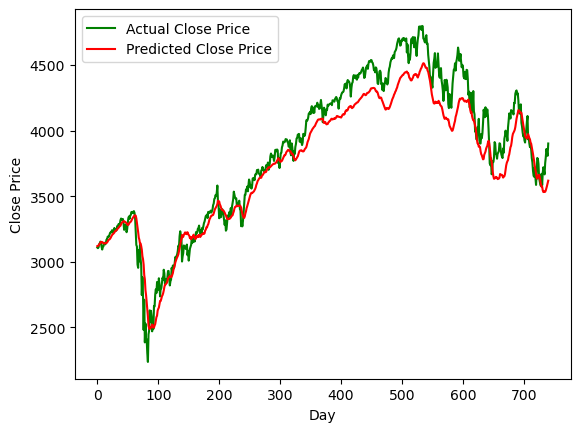

r2_score=0.915189304234991, mse=27690.8047700651


In [80]:
looks = [1,5,10,20,30,50,100]
for look_back in looks:
    X_train, X_test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
    X_train, Y_train, X_test, Y_test = make_train_test(X_train, X_test, look_back)
    
    model=Sequential()
    model.add(LSTM(200, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(LSTM(200, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    print(f'look_back = {look_back}\n')
    check_model(model, X_test, Y_test)

Наблюдение: учет слишком старых данных в рассматриваемой задаче вреден